In [1]:
import qutip as qt
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

import matplotlib.ticker as ticker


from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm
from scipy.integrate import simpson

%matplotlib inline

In [2]:



plt.rcParams.update({
    "text.usetex": True,
    #"text.latex.preamble": r"\boldmath",
    #"font.family": "sans-serif",
    "mathtext.fontset" : "stix",
    "font.family" : "lmodern", #   "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #"text.latex.preamble": r"\usepackage[T1]{fontenc}  \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.4,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.4,     # distance to the minor tick label in points
    #
    "xtick.major.size": 5.5, 
    "ytick.major.size": 5.5,
    
    "xtick.minor.size": 3.5, 
    "ytick.minor.size": 3.5,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "white",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})



In [3]:
### Functions for evaluating the dominant eigenvalue

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx

def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
    else: raise ValueError('You have to choose or left or right')
         
    # Get the maximum eigenvalue and its corresponding index
    dominant_e, idx = Get_maximum(e_values)

    # Get dimension
    d = int(np.sqrt(np.shape(Ws)[0]))
    
    # reshaping the result
    e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
    # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
    return e_values[idx], e_mat/np.trace(e_mat)

In [13]:

def Apply_Tilted_lindblad_normed(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    drho = drho - rho * np.trace(np.reshape(drho, (2,2)))

    # Return the time derivative of rho, flattened back to a 1D array
    return drho


def Apply_Tilted_lindblad(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    # Return the time derivative of rho, flattened back to a 1D array
    return drho

# Get exact diagonalization

In [5]:

def get_exact_diagonalization(tlist, H, Lm, args):
    #### Exact diagonalization 
    e_vals = []
    e_vecs = []

    for t in tlist:
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        e_vals.append(e_val)
        e_vecs.append(qt.Qobj(e_vec))
    
    return e_vecs

# Model

In [27]:
def driving(t, args):

    if t < args["tau"]/2:
        return args["laser"]*np.cos(np.pi*(2*t/args["tau"]))
    else:
        return args["laser"]*np.sin(np.pi*(2*t/args["tau"]))


In [28]:
####
#### Vectorized tilted operator
####

def Tilted_lindbladian(t, args):

    H = args["H"]
    Lm = args["Lm"] 
    H0 = H[0] 
    H1 = H[1][0]

    driving_t = H[1][1]

    Ide = qt.qeye(2)

    Flat_H0    = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()  

    Flat_H1    = -1.0j*(qt.tensor(Ide, H1) - qt.tensor(H1.trans(), Ide)).full()  

    Flat_inco_m = -(1.0/2.0)*(qt.tensor(Ide, Lm.dag()*Lm) + qt.tensor((Lm.dag()*Lm).trans(), Ide)).full()

    Flat_jump_m = (qt.tensor(Lm.conj(),Lm)).full()

       
    Wst = (Flat_H0 * args["omega"]
         + Flat_H1 * driving_t(t, args)
         + Flat_inco_m * args["gamma"] 
         + Flat_jump_m * args["gamma"] * np.exp(-args["s"]))

    return Wst.astype(complex)
              

# Parameters 

In [153]:
H0 = (qt.qeye(2) + qt.sigmaz())/2
H1 = qt.sigmax()

Lm = qt.sigmam()

######## Parameters 

s = 0.5
laser = 1.0
omega = 1.0
gamma = 1.0

tau = 100
Nsteps = 1000
tlist = np.linspace(0, tau, Nsteps)

####### Hamiltonian and jumping operators 
H = [H0, [H1, driving]]

c_ops = [np.sqrt(gamma)*Lm]

###### Initial state 

rho0 = (1/2)*(qt.basis(2,0)+qt.basis(2,1))*(qt.basis(2,1).dag() + qt.basis(2,0).dag())

###### Arg dict 

args  = {"s":s,
         "laser":laser,
         "omega":omega,
         "gamma":gamma,
         "tau":tau,
         "H": H,
         "Lm":Lm,
         "Nsteps":Nsteps}


# Instantaneous Fidelity 

In [62]:
##
## Fig a) 
##

def get_Fidelity_tau(rho0, H, Lm, tlist, taulist=[1, 10, 100]): 
    taus = [1, 10, 100]
    Fidelity_list = []
    Tlist_list = []
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()

    for tau in taulist:
        tlist = np.linspace(0, tau, Nsteps)
        args["tau"] = tau
        args_int = (args, )
        t_span = (0, tau)

        sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                (0, tau), 
                rho0_int, 
                t_eval=tlist, 
                args=(args, ), 
                #method="DOP853", 
                method="BDF",
                rtol=1e-6, 
                atol=1e-9)

        print(sol.success, sol.status)
        e_vals = []
        e_vecs = []
        for t in tlist:
            Ws = Tilted_lindbladian(t, args)
            e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
            e_vals.append(e_val)
            e_vecs.append(qt.Qobj(e_vec))
    
        states_int = [qt.Qobj(state.reshape((2,2))) for state in sol.y.transpose()]

        Fidelity_list.append([qt.fidelity(states_int[i], e_vecs[i]) for i in range(Nsteps)])
        Tlist_list.append(tlist)
    return Tlist_list, Fidelity_list


In [63]:
Tlist_list, Fidelity_list = get_Fidelity_tau(rho0, H, Lm, tlist, taulist=[2, 20, 300])

True 0
True 0
True 0


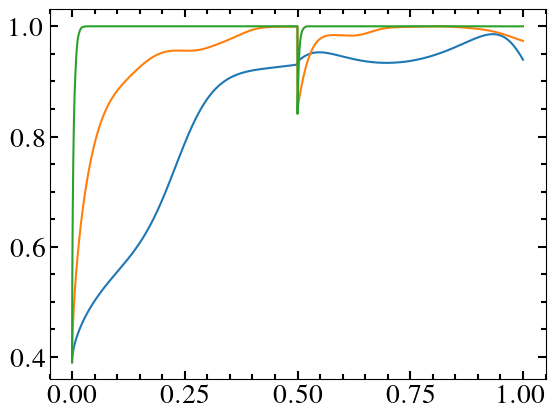

In [64]:
plt.plot(Tlist_list[0]/Tlist_list[0][-1], Fidelity_list[0])
plt.plot(Tlist_list[1]/Tlist_list[1][-1], Fidelity_list[1])
plt.plot(Tlist_list[2]/Tlist_list[2][-1], Fidelity_list[2])

# Integrated fidelity 

In [154]:

def Fidelity_taulist_s(rho0, tau_list, slist, args):

    rho0_int = np.array(rho0,dtype=np.complex_).flatten()
    
    Fidelity_taulist_s = []

    args_aux = args.copy() 

    for s in slist:
        
        Fidelity_taulist = []
        args_aux["s"] = s 
        
        for tau in tau_list:
    
            tlist = np.linspace(0, tau, args["Nsteps"])
            args_aux["tau"] = tau

            sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                            (0, tau), 
                            rho0_int, 
                            t_eval=tlist, 
                            args= (args_aux, ), 
                            method="DOP853", 
                            rtol=10e-12, 
                            atol=10e-15)
            print("For tau= {:.3f}, the solver finished with {} and states {}".format(tau, sol.success, sol.status))
    
            evolved_rho = [qt.Qobj(sol.y.transpose()[i].reshape((2,2))) for i, t in enumerate(tlist)]
    
            Ws_list = [Tilted_lindbladian(t, args_aux) for t in tlist]
            e_vec_list = [Numeric_diagonalization(Ws, side="right")[1] for Ws in Ws_list]
            rho_list = [qt.Qobj(e_vec) for e_vec in e_vec_list]
    
            Fidelity_tlists = [qt.fidelity(rho_list[i], evolved_rho[i]) for i, t in enumerate(tlist)]
    
            Fidelity_taulist.append(simpson(Fidelity_tlists, tlist)/tau)

        print("End of {}\n".format(s))
        Fidelity_taulist_s.append(Fidelity_taulist)
    return Fidelity_taulist_s

In [155]:
slist = [-0.5, 0, 0.5]
tau_list = np.logspace(-2, np.log10(2*100), 100)
FTs = Fidelity_taulist_s(rho0, tau_list, slist, args)

For tau= 0.010, the solver finished with True and states 0
For tau= 0.011, the solver finished with True and states 0
For tau= 0.012, the solver finished with True and states 0
For tau= 0.014, the solver finished with True and states 0
For tau= 0.015, the solver finished with True and states 0
For tau= 0.016, the solver finished with True and states 0
For tau= 0.018, the solver finished with True and states 0
For tau= 0.020, the solver finished with True and states 0
For tau= 0.022, the solver finished with True and states 0
For tau= 0.025, the solver finished with True and states 0
For tau= 0.027, the solver finished with True and states 0
For tau= 0.030, the solver finished with True and states 0
For tau= 0.033, the solver finished with True and states 0
For tau= 0.037, the solver finished with True and states 0
For tau= 0.041, the solver finished with True and states 0
For tau= 0.045, the solver finished with True and states 0
For tau= 0.050, the solver finished with True and states

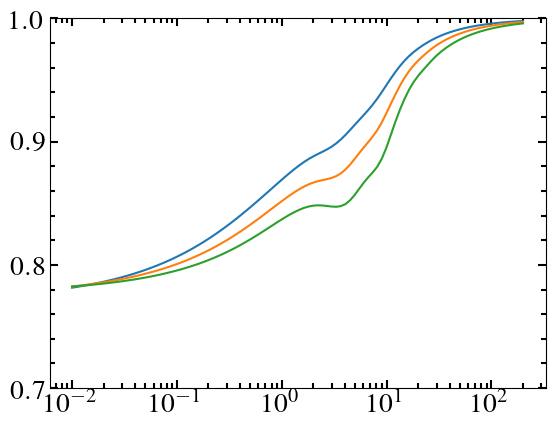

In [156]:
plt.plot(tau_list, FTs[0])
plt.plot(tau_list, FTs[1])
plt.plot(tau_list, FTs[2])

plt.ylim((0.7, 1))

plt.xscale("log")

# Evaluating Theta 

# Exact theta 

In [115]:
####
#### Evaluating numerically the exact theta
####

def get_Exact_theta(slist, args):
    
    exact_theta = []
    args_aux = args.copy()
    tlist = np.linspace(0, 1, args["Nsteps"])
    
    for i, s in enumerate(slist):
        print("{} out of {} - s = {:.3f} \n".format(i, len(slist), s))
        args_aux["tau"] = 1
        args_aux["s"] = s
        e_vals = []

        for t in tlist:
            Ws = Tilted_lindbladian(t, args_aux)
            e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
            e_vals.append(e_val)

        exact_theta.append(simpson(e_vals, tlist))
    return np.array(exact_theta).real

# Theta for different taus 

In [144]:
def get_theta_tau(taulist, s_list, rho0, args): 

    
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()
    args_aux = args.copy()
 
    Tlist_list = []
    thetas = []
    
    for tau in taulist:
        aux = []
        for s in s_list:
            tlist = np.linspace(0, tau, args_aux["Nsteps"])
            args_aux["tau"] = tau
            args_aux["s"] = s

            sol = solve_ivp(Apply_Tilted_lindblad, 
                    (0, tau), 
                    rho0_int, 
                    t_eval=[0, tau], 
                    args=(args_aux, ), 
                    method="DOP853", 
                    rtol=10e-9, 
                    atol=10e-12)
            print("tau = {:.1f}, s = {:.3f} - Solver: success= {}, status {}".format(
                                                                    tau, s, sol.success, sol.status))
            evolved_rho = qt.Qobj(sol.y.transpose()[-1].reshape((2,2)))
            aux.append((1/tau)*np.log(evolved_rho.tr()))
            
        Tlist_list.append(tlist)    
        thetas.append(aux)
    return Tlist_list, thetas 

In [147]:
taus = [1, 10, 100]
s_list_exact = np.linspace(-1, 1, 20)

exact_theta = get_Exact_theta(s_list_exact, args)

Tlist_list, thetas = get_theta_tau(taus, s_list_exact, rho0, args)

0 out of 20 - s = -1.000 

1 out of 20 - s = -0.895 

2 out of 20 - s = -0.789 

3 out of 20 - s = -0.684 

4 out of 20 - s = -0.579 

5 out of 20 - s = -0.474 

6 out of 20 - s = -0.368 

7 out of 20 - s = -0.263 

8 out of 20 - s = -0.158 

9 out of 20 - s = -0.053 

10 out of 20 - s = 0.053 

11 out of 20 - s = 0.158 

12 out of 20 - s = 0.263 

13 out of 20 - s = 0.368 

14 out of 20 - s = 0.474 

15 out of 20 - s = 0.579 

16 out of 20 - s = 0.684 

17 out of 20 - s = 0.789 

18 out of 20 - s = 0.895 

19 out of 20 - s = 1.000 

tau = 1.0, s = -1.000 - Solver: success= True, status 0
tau = 1.0, s = -0.895 - Solver: success= True, status 0
tau = 1.0, s = -0.789 - Solver: success= True, status 0
tau = 1.0, s = -0.684 - Solver: success= True, status 0
tau = 1.0, s = -0.579 - Solver: success= True, status 0
tau = 1.0, s = -0.474 - Solver: success= True, status 0
tau = 1.0, s = -0.368 - Solver: success= True, status 0
tau = 1.0, s = -0.263 - Solver: success= True, status 0
tau = 1.0, s

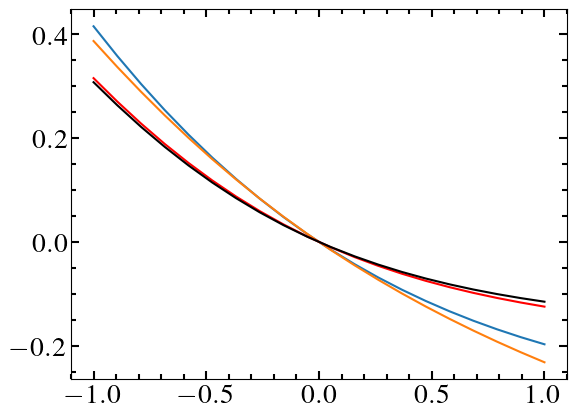

In [148]:
plt.plot(s_list_exact, thetas[0])
plt.plot(s_list_exact, thetas[1])
plt.plot(s_list_exact, thetas[2], color="red")

plt.plot(s_list_exact, np.array(exact_theta).real, color="black")

# Plotting 

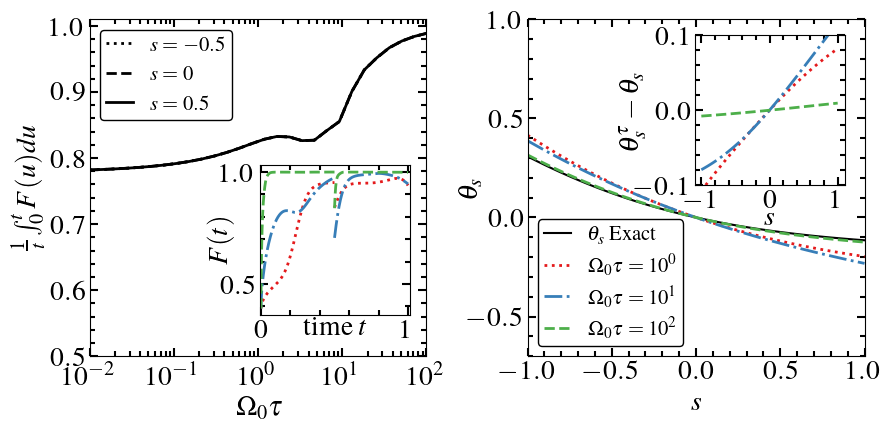

In [56]:

fig, ax = plt.subplots(1,2, figsize=(10,5))

#######################



##########




ax[0].plot(tau_list,FTs[0], color="black", linestyle=":", label=r"$s=-0.5$", linewidth=2)
ax[0].plot(tau_list,FTs[1], color="black", linestyle="--", label=r"$s=0$", linewidth=2)
ax[0].plot(tau_list,FTs[2], color="black", linestyle="-", label=r"$s=0.5$", linewidth=2)

ax[0].set_xlabel(r"$\Omega_0\tau$")
ax[0].set_ylabel(r"$\frac{1}{t} \int_0^tF(u)du$")
ax[0].set_xscale("log")

ax[0].set_xticks([0.01, 0.1, 1, 10, 100])

ax[0].tick_params(axis='x', pad=7)

ax[0].set_ylim((0.5, 1.01))
ax[0].set_xlim((0.01, 100))


ax[0].set_box_aspect(1)

ax[0].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=2)





left0, bottom0, width0, height0 = [0.24, 0.24, 0.26, 0.3]
ax0 = fig.add_axes([left0, bottom0, width0, height0])

ax0.plot(Tlist_list[0][:int(Nsteps/2)]/max(Tlist_list[0]), Fidelity_list[0][:int(Nsteps/2)], color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle=":" , linewidth=2)
ax0.plot(Tlist_list[1][:int(Nsteps/2)]/max(Tlist_list[1]), Fidelity_list[1][:int(Nsteps/2)], color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax0.plot(Tlist_list[2][:int(Nsteps/2)]/max(Tlist_list[2]), Fidelity_list[2][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax0.plot(Tlist_list[0][int(Nsteps/2):]/max(Tlist_list[0]), Fidelity_list[0][int(Nsteps/2):], color="#e41a1c",linestyle=":" , linewidth=2)
ax0.plot(Tlist_list[1][int(Nsteps/2):]/max(Tlist_list[1]), Fidelity_list[1][int(Nsteps/2):], color="#377eb8",linestyle="-.", linewidth=2)
ax0.plot(Tlist_list[2][int(Nsteps/2):]/max(Tlist_list[2]), Fidelity_list[2][int(Nsteps/2):], color="#4daf4a",linestyle="--", linewidth=2)


ax0.set_xlabel(r"time $t$", labelpad=-20)
ax0.set_ylabel(r"$F(t)$", labelpad=-10)
ax0.set_box_aspect(1)

ax0.set_xlim((-0.01, 1.01))


#ax0.set_box_aspect(1)
ax[1].plot(s_list, np.array(exact_theta).real, color="black", label=r"$\theta_s$ Exact")


ax[1].plot(s_list, np.array(thetas[0]).real,color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle=":", linewidth=2)
ax[1].plot(s_list, np.array(thetas[1]).real,color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[1].plot(s_list, np.array(thetas[2]).real,color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)


ax[1].set_xlabel(r"$s$")
ax[1].set_ylabel(r"$\theta_s$", labelpad=-12)
ax[1].set_ylim((-0.7,1))
ax[1].set_xlim((-1,1))

ax[1].set_box_aspect(1)


ax[1].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=3)

left1, bottom1, width1, height1 = [0.63, 0.50, 0.35, 0.3]
ax1 = fig.add_axes([left1, bottom1, width1, height1])
ax1.set_box_aspect(1)

ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[0])).real,color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle=":", linewidth=2)
ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[1])).real,color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax1.plot(s_list, (np.array(exact_theta)-np.array(thetas[2])).real,color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax1.set_ylabel(r"$\theta_s^\tau - \theta_s$", labelpad=-8)

ax1.set_xlabel(r"$s$", labelpad=-6)

ax1.set_ylim((-0.1, 0.1))

plt.subplots_adjust(wspace=0.3)

plt.savefig("Fig2.pdf", bbox_inches="tight")



/Users/paulo/miniconda3/envs/science/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


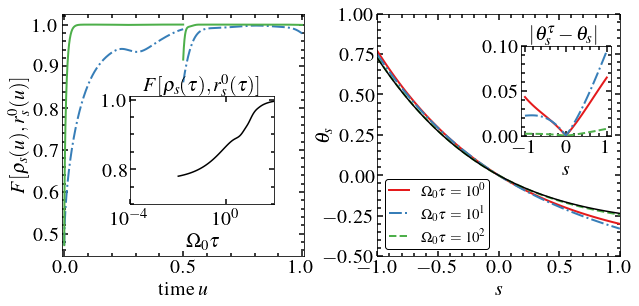

In [66]:

fig, ax = plt.subplots(1,2, figsize=(10,5))

#######################



##########
#ax[0].plot(Tlist_list[0][:int(Nsteps/2)]/max(Tlist_list[0]), Fidelity_list[0][:int(Nsteps/2)], color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-" , linewidth=2)
ax[0].plot(Tlist_list[1][:int(Nsteps/2)]/max(Tlist_list[1]), Fidelity_list[1][:int(Nsteps/2)], color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[0].plot(Tlist_list[2][:int(Nsteps/2)]/max(Tlist_list[2]), Fidelity_list[2][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="-", linewidth=2)

#ax[0].plot(Tlist_list[0][int(Nsteps/2):]/max(Tlist_list[0]), Fidelity_list[0][int(Nsteps/2):], color="#e41a1c",linestyle="-" , linewidth=2)
ax[0].plot(Tlist_list[1][int(Nsteps/2):]/max(Tlist_list[1]), Fidelity_list[1][int(Nsteps/2):], color="#377eb8",linestyle="-.", linewidth=2)
ax[0].plot(Tlist_list[2][int(Nsteps/2):]/max(Tlist_list[2]), Fidelity_list[2][int(Nsteps/2):], color="#4daf4a",linestyle="-", linewidth=2)


ax[0].set_xlabel(r"time $u$")
ax[0].set_ylabel(r"$F[\rho_s(u), r_s^0(u)]$")

ax[0].set_xlim((-0.01, 1.01))
#ax[0].legend(edgecolor="black", framealpha=1,handlelength=0.7,borderpad=0.4)

ax[0].set_box_aspect(1)


left0, bottom0, width0, height0 = [0.22, 0.31, 0.2, 0.3]
ax0 = fig.add_axes([left0, bottom0, width0, height0])

ax0.plot(tau_list,np.array(Fidelity_taulist)/tau_list, color="black")
ax0.set_xlabel(r"$\Omega_0\tau$")
ax0.set_title(r"$F[\rho_s(\tau), r_s^0(\tau)]$")
ax0.set_xscale("log")

ax0.tick_params(axis='x', pad=7)

ax0.set_ylim((0.7, 1.01))
ax0.set_xlim((0.0001, 100))

#ax0.set_box_aspect(1)

ax[1].plot(s_list, thetas[0],color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax[1].plot(s_list, thetas[1],color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax[1].plot(s_list, thetas[2],color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax[1].plot(s_list, exact_theta, color="black")

ax[1].set_xlabel(r"$s$")
ax[1].set_ylabel(r"$\theta_s$", labelpad=-10)
ax[1].set_ylim((-0.5,1))
ax[1].set_xlim((-1,1))

ax[1].set_box_aspect(1)


ax[1].legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=3)

left1, bottom1, width1, height1 = [0.7, 0.50, 0.25, 0.25]
ax1 = fig.add_axes([left1, bottom1, width1, height1])
ax1.set_box_aspect(1)


ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[0])),color="#e41a1c", label=r"$\Omega_0\tau=10^0$", linestyle="-", linewidth=2)
ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[1])),color="#377eb8", label=r"$\Omega_0\tau=10^1$", linestyle="-.", linewidth=2)
ax1.plot(s_list, np.abs(np.array(exact_theta)-np.array(thetas[2])),color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle="--", linewidth=2)

ax1.set_title(r"$|\theta_s^\tau - \theta_s|$")
#ax1.plot(s_list, exact_theta, color="black")

ax1.set_xlabel(r"$s$")

ax1.set_ylim((0.0, 0.1))

plt.subplots_adjust(wspace=0.3)

plt.savefig("Fig2.pdf", bbox_inches="tight")

